# Lyapunov

In [1]:
import numpy as np
import queue
import ipdb
import matplotlib.pyplot as plt
import pickle
import sympy as sp
import random as rand

In [2]:
class Packet(object):
    
    def __init__(self, queueNum, arrivalTime):
        global MESID
    
        try:
            MESID +=1
        except NameError:
            MESID = 0    
    
        self.pid = MESID
        self.queueNum = queueNum
        self.arrivalTime = arrivalTime
        self.isSent = False
        self.sentTime = -1
        
    def __repr__(self):
        return str([self.pid, self.queueNum, self.arrivalTime, self.sentTime, self.delayTime])
        
    def __str__(self):
        return str([self.pid, self.queueNum, self.arrivalTime, self.sentTime, self.delayTime])
    
    def send(self, sentTime):
        self.isSent = True
        self.sentTime = sentTime
        self.delayTime = self.sentTime - self.arrivalTime
        
        return self
    
    @staticmethod
    def resetIDs():
        global MESID
        MESID=-1

In [36]:
def getS(probs):
    return np.random.choice(len(probs), p=probs)
    
def getA(l):
    #return np.random.poisson(l)
    return np.random.binomial(1,l)

def getLmdas(flmdas, numPoints):
    return list(map(list, zip(*[list(np.linspace(0, flmdas[0], num=numPoints)), list(np.linspace(0, flmdas[1], num=numPoints))])))

def lyapunov(lmda, Sp, finalT):
    # initialize queues
    NUMQ = len(lmda)
    Q = [queue.Queue()]*NUMQ
    Packet.resetIDs()
    sentPackets = []
    Backlogs = []

    for t in np.arange(finalT):
        
        St = [getS(Sp[i]) for i in np.arange(NUMQ)]
        Qt = [q.qsize() for q in Q]

        Backlogs.append(Qt)
    
        maxW = [q*s for q,s in zip(Qt,St)]
    
        alpha = maxW.index(max(maxW))
    
        # Send packets
        for pNum in np.arange(St[alpha]):
        
            if Q[alpha].empty():
                break
        
            packet = Q[alpha].get()
            sentPackets.append(packet.send(t))
            
        # Packets arrive
        for i in np.arange(NUMQ):
            for packet in np.arange(getA(lmda[i])):
                Q[i].put(Packet(i, t))
    
    return Backlogs

## Simulate

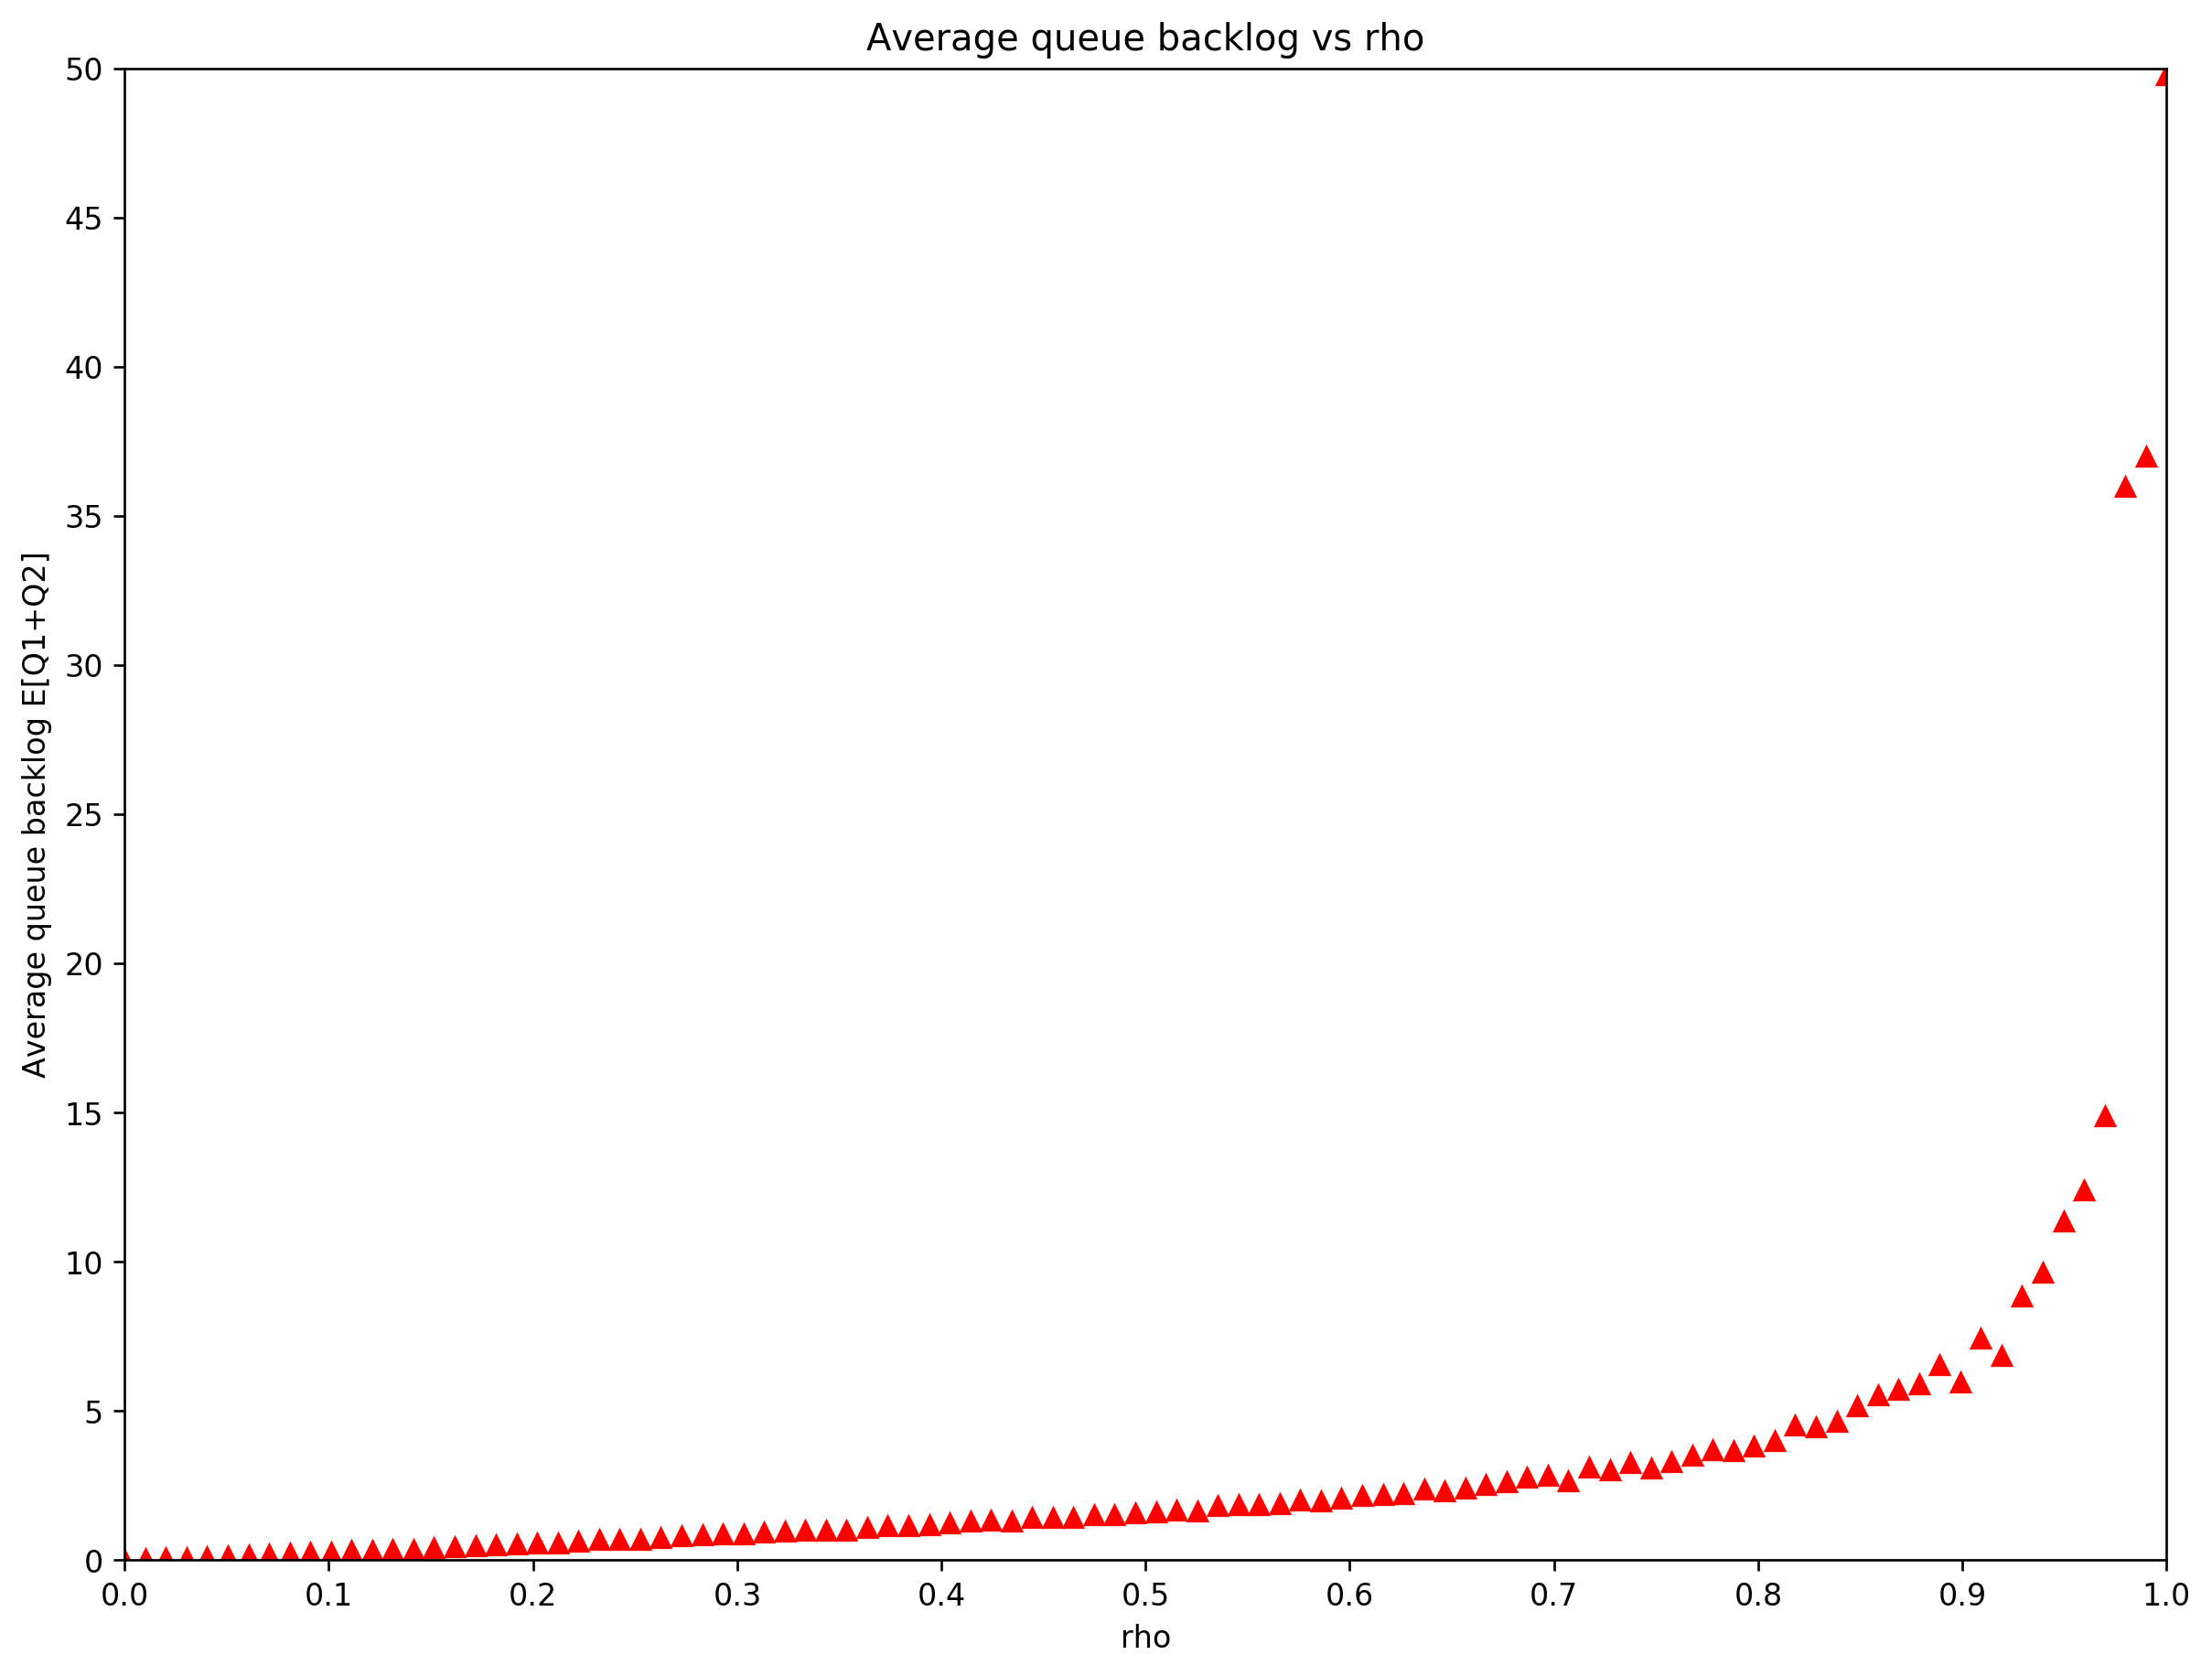

In [37]:
Z = [0.372, 0.868]
Sprobs = [[0.3, 0.7], [0.2, 0.5, 0.3]]
num = 100
fT = 10000 #10**6
avgBacklogs = []

for lmdas in getLmdas(Z, num):
    backlogs = lyapunov(lmdas, Sprobs, fT)
    avgBacklogs.append(np.mean([sum(backlog) for backlog in backlogs]))
    
fig = plt.figure(num=None, figsize=(12, 9), dpi=240, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0, 1, num), avgBacklogs, 'r^')
plt.title('Average queue backlog vs rho')
plt.xlabel('rho')
plt.ylabel('Average queue backlog E[Q1+Q2]')
plt.axis([0, 1, 0, 50])
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 55, 5))
#plt.legend(["rhoH", "2rhoH", "2.5rhoH", "10rhoH"])
plt.show()